In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import mlfinlab as ml
import datetime
import scipy
from alpha_vantage.timeseries import TimeSeries
from multiprocessing import cpu_count
%matplotlib inline

/Users/marcusahlgren/.local/share/virtualenvs/financial_ML-WJfqPqib/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/marcusahlgren/.local/share/virtualenvs/financial_ML-WJfqPqib/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#set credentials for stock API
ts = TimeSeries(key = 'PTME3FLJAHB9CY', output_format = 'pandas')

In [3]:
#define global variables
DATE = "date"
PRICE = "4. close"
VOLUME = "5. volume"

In [4]:
#load sample data
data, meta_data = ts.get_daily_adjusted(symbol = 'MSFT', outputsize = 'full')

In [5]:
data = data.sort_index(ascending = True)

To find parts of a time series where shifts in the mean occur we use the CUSUM filter. The hypiothesis is that these periods of the time series has relatively high signal-to-noise-ratio.

In [6]:
#get timestamps where close prices shifts in the mean are detected using CUSUM filter. We try two different thresholds.
daily_vol = ml.util.get_daily_vol(data[PRICE], lookback = 60)
events1 = ml.filters.cusum_filter(data[PRICE], daily_vol.mean() * 5)
events2 = ml.filters.cusum_filter(data[PRICE], daily_vol.mean() * 10)

/Users/marcusahlgren/.local/share/virtualenvs/financial_ML-WJfqPqib/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


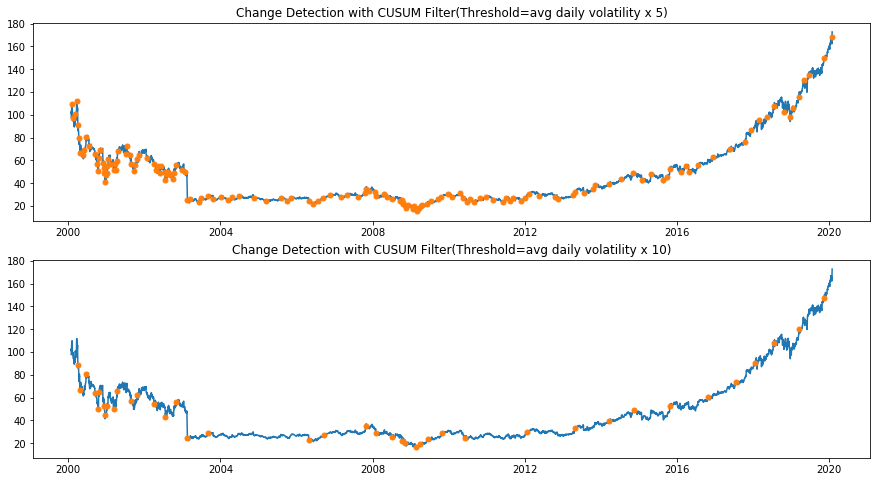

In [7]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 8))
axes[0].plot(data[PRICE])
axes[0].plot(data.loc[events1][PRICE], "o", markersize = 5)
axes[1].plot(data[PRICE])
axes[1].plot(data.loc[events2][PRICE], "o", markersize = 5)
axes[0].set_title("Change Detection with CUSUM Filter(Threshold=avg daily volatility x 5)")
axes[1].set_title("Change Detection with CUSUM Filter(Threshold=avg daily volatility x 10)")
plt.show()

As depicted above the sensitivity of the CUSUM filter can be tuned to only capture the most drastic shifts in a time series.

We now compute a triple barrier search for the events found in the first figure above. 
The maximum holding time is set to 14 days and the stop loss is set to 5%.

In [65]:
#compute times of vertical barriers 
vertical_barrier = ml.labeling.add_vertical_barrier(events1, data[PRICE], num_days = 14)

In [66]:
#stop loss levels is set by trgt * pt_sl. In this case trgt = 1 for all times and pt_sl = [0.05, 0.05].
#This yields a constant stop loss at 1 * 0.05 = 5%. Stop loss can also be dynamic by for instance using target = daily volume
trgt = pd.Series(index = data.index, data = 1)
triple = ml.labeling.get_events(close = data[PRICE],
                                t_events =  events1,
                                pt_sl = 2 * [0.05],
                                target = trgt,
                                min_ret = 0.1,
                                num_threads = 1,
                                vertical_barrier_times = vertical_barrier)

In [67]:
#compute labels from the triple barrier search.
#Upper barrier => 1
#Vertical barrier =>0
#Lower barrier => -1
labels = ml.labeling.get_bins(triple, data[PRICE])

,ret,trgt,bin
2000-02-08,-0.054029,1,-1
2000-02-16,-0.064638,1,-1
2000-03-10,-0.058218,1,-1
2000-03-23,-0.069813,1,-1
2000-04-03,-0.053593,1,-1


In [68]:
temp_df = triple.merge(data[[PRICE]], left_index = True, right_index = True, how = "left")
temp_df["vertical_barrier"] = temp_df.index + pd.Timedelta(days = 14)
temp_df = temp_df.reset_index()
temp_df["upper"] = temp_df[PRICE] * (temp_df["trgt"] * temp_df["pt"] + 1)
temp_df["lower"] = temp_df[PRICE] * (temp_df["trgt"] * -temp_df["sl"] + 1)
temp_df = temp_df.dropna()

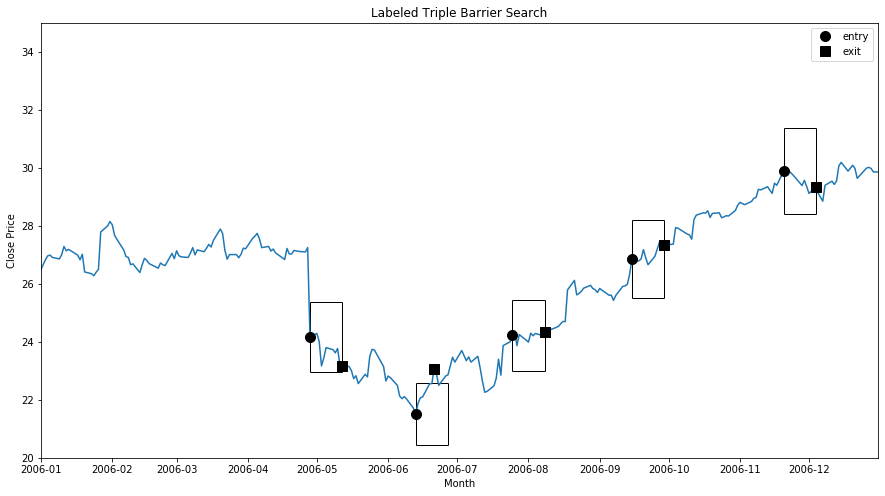

In [75]:
fig, ax = plt.subplots( figsize = (15, 8))
ax.plot(data[PRICE])
ax.plot(temp_df.set_index("index")[PRICE], "o", markersize = 10, color = "black", label = "entry")
ax.plot(data.loc[temp_df["t1"]][PRICE], "s", markersize = 10, color = "black", label = "exit")
ax.set_xlim(datetime.datetime(2006, 1, 1), datetime.datetime(2006, 12, 31))
ax.set_ylim(20, 35)
[plt.hlines(y = row["upper"], xmin = row["index"], xmax = row["vertical_barrier"], linewidth = 1, linestyle = "-", color = "black") for index, row in temp_df.iterrows()]
[plt.hlines(y = row["lower"], xmin = row["index"], xmax = row["vertical_barrier"], linewidth = 1, linestyle = "-", color = "black") for index, row in temp_df.iterrows()]
[plt.vlines(x = row["index"], ymin = row["lower"], ymax = row["upper"], linewidth = 1, linestyle = "-", color = "black") for index, row in temp_df.iterrows()]
[plt.vlines(x = row["vertical_barrier"], ymin = row["lower"], ymax = row["upper"], linewidth = 1, linestyle = "-", color = "black") for index, row in temp_df.iterrows()]
ax.set_title("Labeled Triple Barrier Search")
ax.set_xlabel("Month")
ax.set_ylabel("Close Price")
plt.legend()
plt.show()

From the plot above we have 5 events in total. 4 cases where the vertical barrier was touched first and 1 case where the upper barrier was crossed first. We confirm this in the slice of the label dataframe.

In [61]:
labels.loc["2006"]

,ret,trgt,bin
2006-04-28,-0.040580,1,0
2006-06-13,0.072989,1,1
2006-07-25,0.004955,1,0
2006-09-15,0.018622,1,0
2006-11-20,-0.018735,1,0


The plots in this notebook shows the essentials of how to label time series snippets with triple barrier search. Hyperparameters such as stop loss and vertical barrier horizon and time series sampling frequency(hourly, daily etc.)  should be experimented with to find good combinations.